# Survival Analysis using Python

Author: Meghan Broadbent    
Professor: Dr. Marlene Egger  
Masters of Biostatistics, University of Utah  
  
  Tutorial provided for class FP MD 6107 - Survival Analysis

______________________________________________________________________________________________________________________

The purpose of this tutorial is to provide an introduction to Python and its use in statistical analysis for a class project. This tutorial assumes the reader is well equipped with statistical knowledge and capability of performing survival analysis

We will follow the documentation for *Lifelines* closely (link here:  http://lifelines.readthedocs.io/en/latest/index.html#). The dataset used for analysis is the German Breast Cancer Study; publically available from the UMASS repository (link here:  https://www.umass.edu/statdata/statdata/). In this example, there are 702 women with breast cancer, 686 of which are followed through time. Variables of interest are the following: Age, Menopausal status, Hormone Therapy, Tumor Size, Tumor Grade (severity), Number of Nodes, Number of Progesterone Receptors, Number of Estrogen Receptors, Time to Recurrence (of breast cancer), Recurrence Censoring, Time to Death, and Death Censoring. *Note: There are other miscellaneous variables in this dataset which serve no statistically useful purpose. We will omit these later *
  
SAS tends to be top dog in regards to survival analytics, so with good reason this entire analysis was verified by running SAS side by side to ensure all output is correct. All supplementary code in SAS is provided as well

To get started, we will need to cover the basics of installing Python, Jupyter, Anaconda, and packages

# Installing

Python is a high-level, dynamic, open source object oriented programming language. This language provides support for many programming paradigms, and is often thought to bridge the gap between the world of software engineering, data science, and statistics. *Lifelines* is a package in Python equipped to perform beyond the basics of survival analysis. In order to utilize this feature of Python, several additional packages are required: *NumPy*, *Pandas*, and *Matplotlib*. Other packages may come in handy, however these three are the necessary basics  
  
  <br>
*Lifelines* is a package in Python, and is an implementation of survival analysis. This follow closely to what the *Lifelines* documentation provides (link here: http://lifelines.readthedocs.io/en/latest/)  

*NumPy* is a package for scientific computing, and is useful for handling dataframes and operating on arrays (link here: http://www.numpy.org/)  

*Pandas* is a package providing easy to use, yet high performance, data structure (link here: http://pandas.pydata.org/)  

*Matplotlib* is a package used for plotting/visualization in Python (link here: http://matplotlib.org/)  
<br>

If you are new to python, then I suggest you start by downloading Python (link here: https://www.python.org/downloads/). This analysis is using Python 3.5. It's also highly suggested you download Anaconda (link here: https://www.continuum.io/downloads). Anaconda is a very useful data science platform in Python that will provide you with all the necessary packages like *NumPy*, *Pandas*, *SciPy*, etc. It will also provide you with the game changer:  Jupyter Notebook (link here: http://jupyter.org/)

What is a Jupyter Notebook? You're looking at it. It's a web platform that runs on your localhost and can run live code, visualize data, explain via test and markup such as HTML and LaTeX all in one place. Not only can you run Python in this, but you can also set it up to run a few other languages, such as R and Julia

When installing packages and other fun things, it may be useful get familiar with your command line and using a *pip install*, which is essentially a command prompt to install things quickly with Python (link here: https://pip.pypa.io/en/stable/installing/, and here: https://docs.python.org/3/installing/, and here: https://www.davidbaumgold.com/tutorials/command-line/)

Lastly, this site you're visiting is Github, a widely popular and incredibly useful collaborative software platform. If you are planning to code or run analysis in the future, I suggest you become familiar with Github (link here: https://guides.github.com/activities/hello-world/)

# Let's get started

After setting yourself up with all the goodies we just discussed above, it's time to import the packages we'll need

In [353]:
#this is how you comment in Python
import random
#naming numpy as np, so if we call it later we just np.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, AalenAdditiveFitter, CoxPHFitter, NelsonAalenFitter
from lifelines.plotting import plot_lifetimes
from lifelines.statistics import logrank_test, pairwise_logrank_test
from lifelines.estimation import NelsonAalenFitter
from numpy.random import exponential
from lifelines.plotting import add_at_risk_counts
#seaborn automatically makes our plots prettier just by importing it
import seaborn as sb
#image will be used to insert .png
from IPython.display import Image
%matplotlib inline

Our German Breast Cancer dataset is provided in either a .dat or .xls format, below we will read in the .xls format using Pandas from this computers Desktop

In [2]:
#reading in our file
file = pd.ExcelFile("Desktop/gbcs.xls")
file

An Excel spreadsheet can have multiple sheet names. You should always check this for several reasons:    

1) You may have more than one sheet name, so you better know which one you'll be using  
2) We need the name of the sheet to parse our data into a Pandas dataframe  
3) Lastly, it's just good practice

In [148]:
file.sheet_names

['GBCS']

We parse our sheet into a readable dataframe, call it `df` for dataframe, then we check the data types using `.dtypes` so we know what we're working with

In [365]:
#parsing the sheet
df = file.parse('GBCS')
#checking the data types
#df.dtypes

Remember how I mentioned we'd be deleting a few columns? Well, these datatime features aren't necessary, nor is the ID. Why? The ID is just an index that provides no statistical meaning. The datetime columns provide the dates of death, but in survival analysis we are concerned with the time until an event. These datetimes don't provide that information and will be very tricky to work with later for analysis if we keep them. Besides, all the information we need for our time until event (death or recurrence) is provided by the survtime and rectime features - which give us the time until death or time until recurrence of breast cancer, measured in days  

Thus, we drop these features using `.drop()` and name this new dataframe cancerData

In [150]:
#axis=1 is for columns, axis=0 is for rows
cancerData=df.drop(['id', 'diagdateb', 'recdate', 'deathdate'], axis=1)

Our primary interest for this analysis will be the time until death given a set of covariates. This event time includes right censoring, where some patients may die during the study period, and some may live to which we gather no event data. The duration of study is 2,668 days total for the 686 women 

*Lifelines* provides a very cool function to visually inspect the lifetimes of the patients using a `plot_lifetimes()` function

Below, we will look at the survival times (between 0 days adn 2668 days) for women with breast cancer and their time until death (or censoring). We can plot a dotted line at the midpoint of the study (1,334 days) to assess how many women live past this point  

To look at a specific column or feature, we have to specify the data frame and what column we're grabbing (similar to R). We do this by either `df['columnName']` or `df.columnName`

*Note: 'df' often refers to 'dataframe' which is usually just the name of the dataset you are working with. In this case we've name ours cancerData*

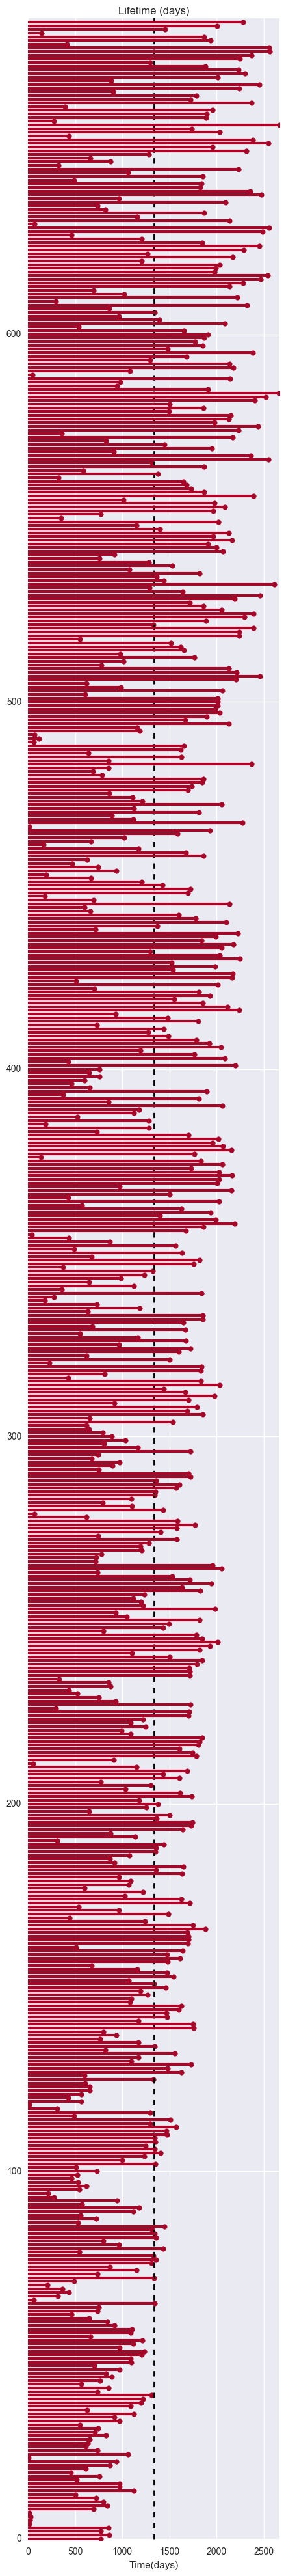

In [151]:
#figure size needs to be large to handle all observations
plt.figure(figsize=(5,50))

#limits of the x axis
plt.xlim(0,2668)

#verticle dashed line at the midpoint starting at y=0 and ending at y=700
plt.vlines(1334,0,700,lw=2,linestyles="--")

#labeling the x axis
plt.xlabel("Time(days)")

#labeling the title 
plt.title("Lifetime (days)")

#plotting the actual data
plot_lifetimes(cancerData['survtime'])

As you can see, this is far too large to be useful. Instead, we can sample from our dataset in order to look at fewer samples using `df.sample(n=numberOfSamples)`. I'm going to show you two ways of doing this 

1) Pull the survival times from our dataframe using a numpy array. We use `.values` to view the array of values in that column   
2) Pull the survival times from our dataframe using a pandas array. In order to view these values we have to reset and drop the index associated with the values using `.reset_index(drop=True)` 
  
Below is an example for each of these methods for sampling 10 observations from our survival time (survtime) column

In [152]:
#pulling values (numpy array)
cancerData.sample(n=10)['survtime'].values

array([1427,  779, 1715,   71, 1940, 1863,  462, 1625, 2017, 2388])

In [153]:
#pulling values (pandas array)
cancerData.sample(n=10)['survtime'].reset_index(drop=True)

0    1789
1    1124
2     762
3     622
4     569
5    1125
6     716
7    1278
8    1557
9     889
Name: survtime, dtype: int64

Now that we have an idea as to what each method is doing, we can sample from our data set and plot the lifetimes as we did before, but instead resulting in a much more useful graph  

Below we will sample 50 survival times and plot using the two methods of sampling from above

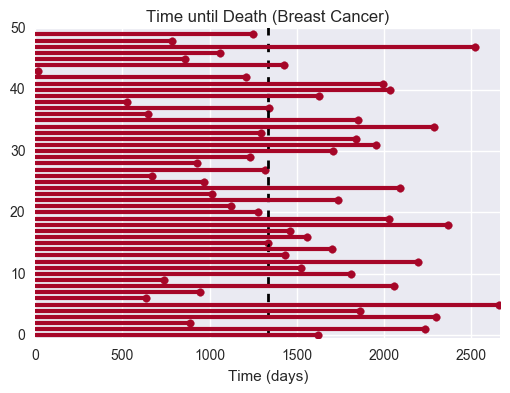

In [374]:
#numpy array method
plt.xlim(0,2668)
plt.vlines(1334,0,700,lw=2,linestyles="--")
plt.xlabel("Time (days)")
plt.title("Time until Death (Breast Cancer)")
plot_lifetimes(cancerData.sample(n=50)['survtime'].values)

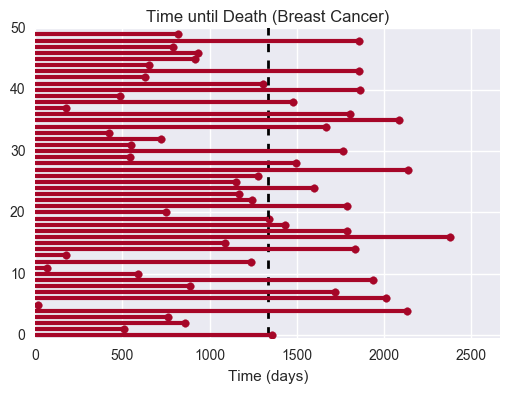

In [372]:
#pandas array method
plt.xlim(0,2668)
plt.vlines(1334,0,700,lw=2,linestyles="--")
plt.xlabel("Time (days)")
plt.title("Time until Death (Breast Cancer)")
plot_lifetimes(cancerData.sample(n=50)['survtime'].reset_index(drop=True))

Notice how these look different? It's because we've plotted different samples. If we keep rerunning these over and over we'll get a different plot each time

# Kaplan Meier

*Lifelines* provides a Kaplan Meier function to visualize the survival curves for any feature(s). When fitting or plotting a survival curve, we use `KaplanMeierFitter()`. It is generally good practice to give this a unique name for each model you run, that way you can call on that model later. We then use the `.fit()` function to fit our data to the model, and `.plot()` to plot. *Note: Python likes to maximize the space in a plot/graph, it's good practice to specify the y-axis limits. For instance, if your survival curve ranged from 0.35-0.65, then Python would output a plot with the y-axis ranging from 0.3-0.7, rather than 0.0-1.0*
  
Below, we will walk through several methods of to obtain these plots

(0, 1)

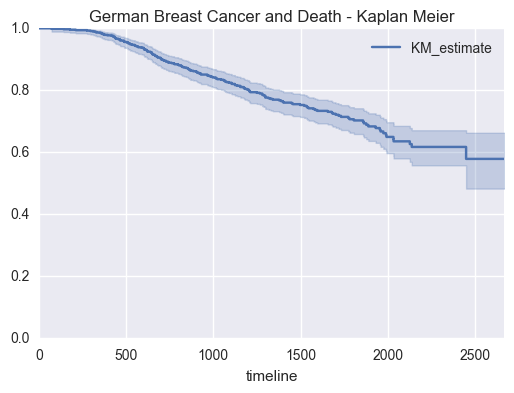

In [261]:
#TIME TILL DEATH

#name this fitter KMd for Kaplan Meier death
KMd = KaplanMeierFitter()

#S will be shorthand for our survival time data
#D similar for death censorhip
S=cancerData['survtime']
D=cancerData['censdead']

#fit the model and plot
KMd.fit(S, event_observed=D)
KMd.plot(title='German Breast Cancer and Death - Kaplan Meier')

#python likes to maximize space on plots, specify your limits
#else this plot would range from 0.4-1.0
plt.ylim([0,1])

We can look at the time until recurrence of breast cancer in a similar fashion as above

(0, 1)

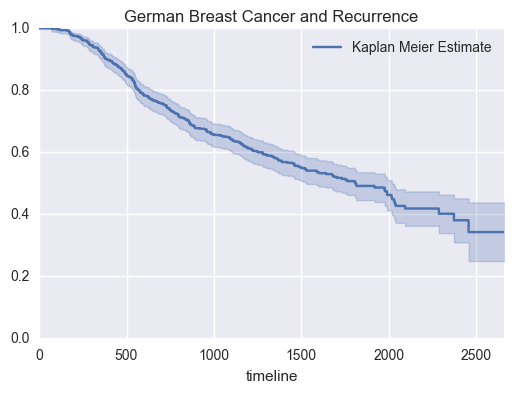

In [260]:
#RECURRENCE
R=cancerData['rectime']
B=cancerData['censrec']
KMr=KaplanMeierFitter()
KMr.fit(R, event_observed=B, label='Kaplan Meier Estimate')
KMr.plot(title='German Breast Cancer and Recurrence')
plt.ylim([0,1])

We can show the tick marks for censoring by specifying `show_censors=True` in our plot function. Below we will demonstrate this, however we omit from using this for this particular anaylsis as there is heavy censoring, and it makes interpretation of the curve(s) a bit difficult

(0, 1)

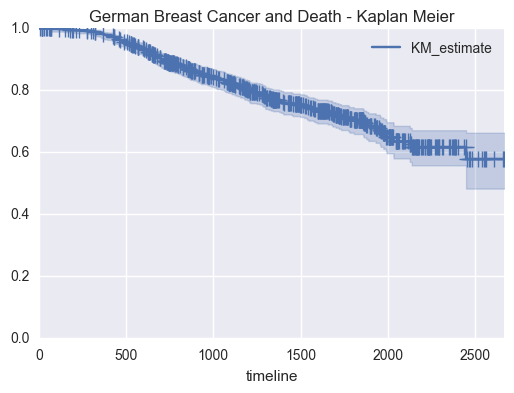

In [265]:
#TIME TILL DEATH - WITH CENSORSHIP SHOWN

#name this fitter KMd for Kaplan Meier death
KMd = KaplanMeierFitter()

#S - survival time data
#D - death censorhip
S=cancerData['survtime']
D=cancerData['censdead']

#fit the model and plot
KMd.fit(S, event_observed=D)
KMd.plot(title='German Breast Cancer and Death - Kaplan Meier', 
         show_censors=True)

#specify the ylimits
plt.ylim([0,1])

# Stratifying and Functions

Let Python do what it does best; object oriented programming   
  

Instead of repeating the same code over and over and... over, we can create a quick function and pass in what we want to model  
  
When plotting these stratified Kaplan Meier curves, we're essentially creating the layout for a plot and then overlaying two separate curves onto it. To make this work we use the `ax` feature from matplotlib which allows us to overlay the axis of each curve onto one plot
  
Below we'll look at how to stratify our Kaplan Meier curve for some covariate, and then we'll create function to do this for us so we aren't relentlessly repeating the same code for each covariate

(0, 1)

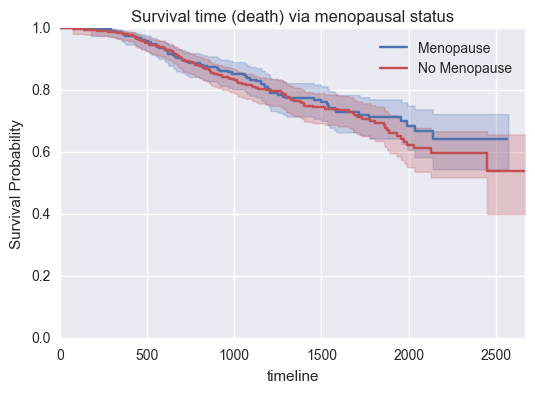

In [358]:
#stratifying for MENOPAUSE status
#menopause == 1 means 'yes', menopause == 2 means 'no'
m1 = cancerData.menopause==1

#set up our kaplan meier fitter for the menopause curve
KMm=KaplanMeierFitter()

#fit the model for women WITH menopause
KMm.fit(S[m], D[m], label='Menopause')

#set the plot of our fit model onto the axis
ax=KMm.plot()

#changes up the colors
ax.plot(range(1))

#set up a new fitter for our no menopause curve
KMnm=KaplanMeierFitter()

#fit the model for women without menopause using ~ as 'not'
KMnm.fit(S[~m], D[~m], label='No Menopause')

#set the y axis label and title
#Note: I'm leaving the x axis alone as it default to 'timeline'
ax.set_ylabel('Survival Probability')
plt.title("Survival time (death) via menopausal status")

#overlay the curve of the plot
KMnm.plot(ax=ax)
plt.ylim([0,1])
#Note: if we didnt want confidence intervals
#we could just say km.plot(ci_show=False)

Time to clean this up with a function! This function will provide a Kaplan Meier curve for a dichotomized variable.  
*Note: In this tutorial I am only defining simple functions for dichotomous features, but these can easily be altered to handle polychotomous features*  
  
The general format of a function is as follows:  
`def functionName(args1, args2, ...):`  
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`do stuff, and/or`  
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`return stuff`
  
Then to call a function we make, we simply type in the function name and the arguments needed   
  
Below, we will define a function called `KapMeier_Death` that takes 4 arguments: `var`, `titleName`, `legend1`, and `legend2`

In [255]:
#defining our KaplanMeier function for time until death
#we've seen all this before, so I won't heavily comment this function 
def KapMeier_Death(var, titleName, legend1, legend2):
    s=cancerData['survtime']
    d=cancerData['censdead']
    
    KM1=KaplanMeierFitter()
    KM1.fit(s[var], d[var], label=legend1)
    ax=KM1.plot()
    
    ax.plot(range(1))
    
    KM2=KaplanMeierFitter()
    KM2.fit(s[~var], d[~var], label=legend2)
    
    ax.set_ylabel('Survival Probability')
    plt.title(titleName)
    
    plt.ylim([0,1])
    KM2.plot(ax=ax)

Now all we need to do it pass in some information to this function. *var* should be the covariate you're interested in stratifying, `titleName` will need to be a string, so we'll pass it into our function with quotations - also doing the same for `legend1` and `legend2` which will the names for our curves  
  
Let's model the survival curves for menopausal status again

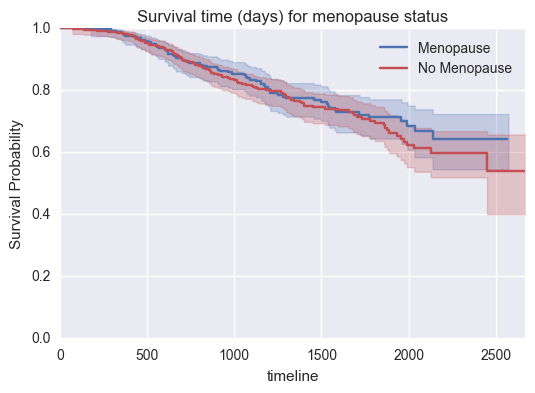

In [256]:
#m1 for menopause is already defined above
KapMeier_Death(m1, "Survival time (days) for menopause status", 'Menopause', 'No Menopause')

This is the same output as before - which is good. It would be cause for concern if our plot came out different. But, since we know this function works, we can use to pass in other information such as stratifying on hormone therapy, cancer nodes, tumor grade, etc  

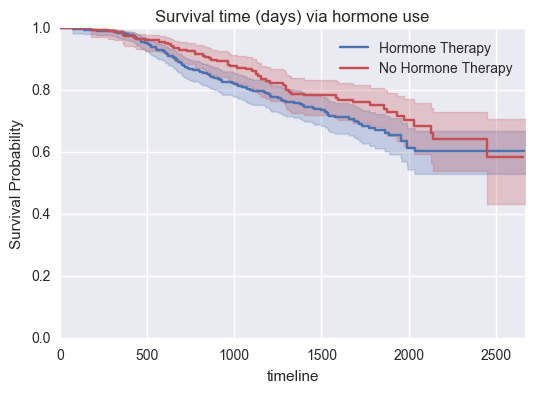

In [257]:
#hormone==1 is 'hormone therapy', hormone==2 is 'no therapy'
h1=cancerData.hormone==1
KapMeier_Death(h1, "Survival time (days) via hormone use", 'Hormone Therapy', 'No Hormone Therapy')

The number of cancer nodes in this data set ranges from 1-51, so we'll dichotomize this variable around the midpoint. We can do this by saying `n=cancerData.nodes>25` and `n1=cancerData.nodes<=25`. But, remember our Kaplan Meier function will use `n` and then `~n` where `~n` would be the same as defining `nodes<=25`, hence we only have to pass in `n`

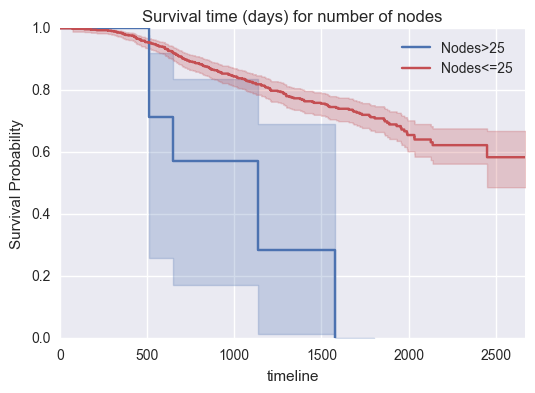

In [258]:
#define the variable of interest, here it's nodes>25
n = cancerData.nodes>25
KapMeier_Death(n, "Survival time (days) for number of nodes", 'Nodes>25', 'Nodes<=25')

This plot indicates there are few women who have 25 or more cancer nodes  
  
  Below, we'll look at tumor grade, a polychotomous feature measure by grade = 1, 2, or 3 (3 the highest in severity)

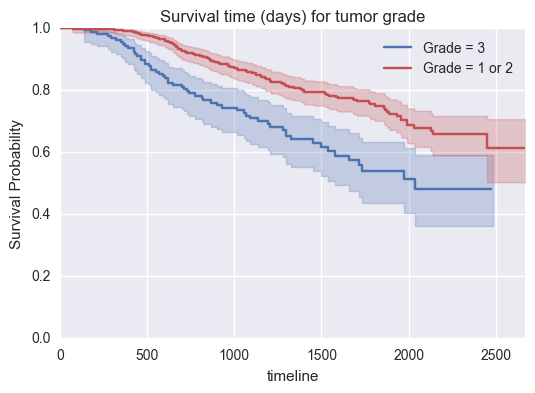

In [186]:
g3 = cancerData.grade==3
KapMeier_Death(g3, "Survival time (days) for tumor grade", 'Grade = 3', 'Grade = 1 or 2')

Tumor grade 3 clearly has lower probability of survival over time than either grade 1 or 2

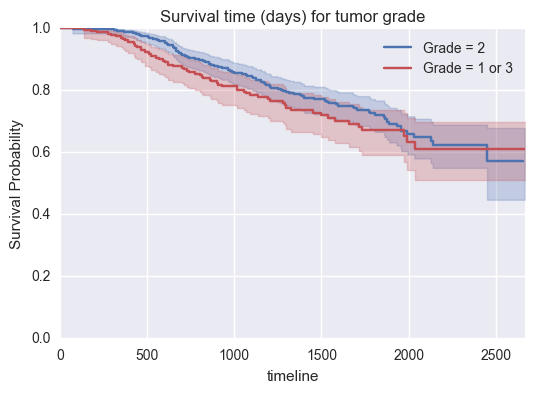

In [185]:
g2 = cancerData.grade==2
KapMeier_Death(g2, "Survival time (days) for tumor grade", 'Grade = 2', 'Grade = 1 or 3')

Tumor grade 2, for the most part, has higher probability of survival over time than grade 1 or 3. Likely, it is tumor grade 3 pulling this probability curve down

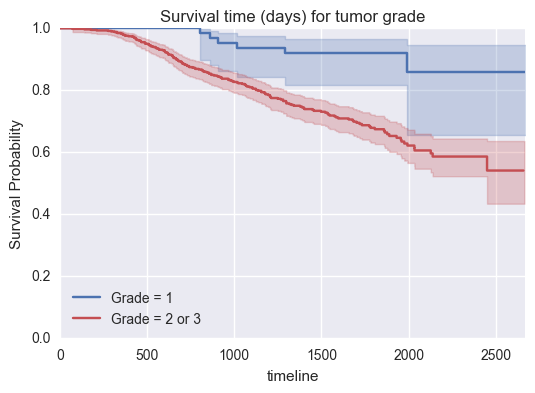

In [184]:
g1 = cancerData.grade==1
KapMeier_Death(g1, "Survival time (days) for tumor grade", 'Grade = 1', 'Grade = 2 or 3')

Tumor grade 1 clearly has a higher probability of survival than grade 2 or 3

Let's look into tumor grade a bit further with an 'at risk' counter. Instead of using our `KapMeier_Death()` function which plots two curves, we'll come up with something new to handle 3 curves  
  
  To do so, we use `ax=plt.subplot(111)`, this is commonly seen from the matplotlib package and creates an axis where `subplots(111)` denotes an axis with one plot. Hence, the `111` will be placing all three plots overlayed in the same place 
  
  We can add an 'at-risk' count for the survival curve at the time points provided, to do so we use the following  
  `add_at_risk_counts(model1, model2, ...., ax=ax)`

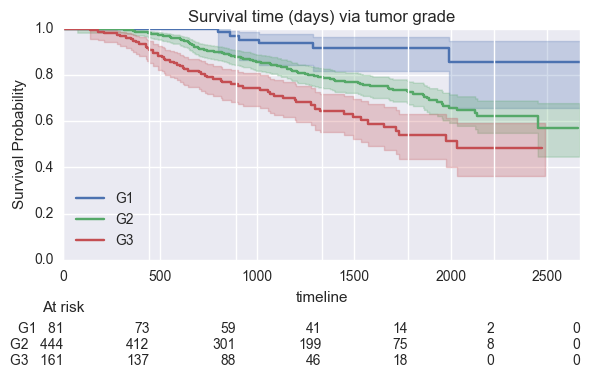

In [376]:
#set up the three plots
ax=plt.subplot(111)

#define the fitter for grade 1
KMg1=KaplanMeierFitter()
KMg1.fit(S[g1], D[g1], label='G1')
KMg1.plot(ax=ax)

#define the fitter for grade 2
KMg2=KaplanMeierFitter()
KMg2.fit(S[g2], D[g2], label='G2')
KMg2.plot(ax=ax)

#define the fitter for grade 3
KMg3=KaplanMeierFitter()
KMg3.fit(S[g3], D[g3], label='G3')
KMg3.plot(ax=ax)

ax.plot(range(1))

#labels
ax.set_ylabel('Survival Probability')
plt.title("Survival time (days) via tumor grade")

#add at risk counts
add_at_risk_counts(KMg1, KMg2, KMg3, ax=ax)

We see that all of the participants with tumor grade 3 die before the end of the study period (2,668 days). Note: by the end of the study no one is 'at risk' (all are 0) since the study has ended. The women still alive at 2,668 days (tumor grades 1 and 2) are right censored

# Stratification  - one step further

Something that Python can do that SAS cannot do? Stratify by different measures of time and censorship. A program like SAS will only take one time argument and one censoring argument, but we define a function to plot both a survival curve for time till death and a survival curve for time till recurrence for one feature (or more than one feature if we wished)  
  
Let's get a look at time to death and time to recurrence for women with menopause

In [275]:
def plot_recurrence_and_death(var, titleName):
    S=cancerData[var]['survtime']
    D=cancerData[var]['censdead']

    R=cancerData[var]['rectime']
    B=cancerData[var]['censrec']

    ax = plt.subplot(111)
    
    KM1=KaplanMeierFitter()
    KM1.fit(S, event_observed=D, label=['Time to death'])
    KM1.survival_function_.plot(ax=ax)
    
    #placing this code after the first model gives colors red and blue
    ax.plot(range(1))
    
    KM2=KaplanMeierFitter()
    KM2.fit(R, event_observed=B, label='Time to recurrence')
    KM2.survival_function_.plot(ax=ax)
    
    ax.plot(range(1))
    ax.set_ylabel('Survival Probability')
    plt.title(titleName)
    
    plt.ylim([0,1])
    
    #plt.gcf() returns the current figure
    KM2=plt.gcf()

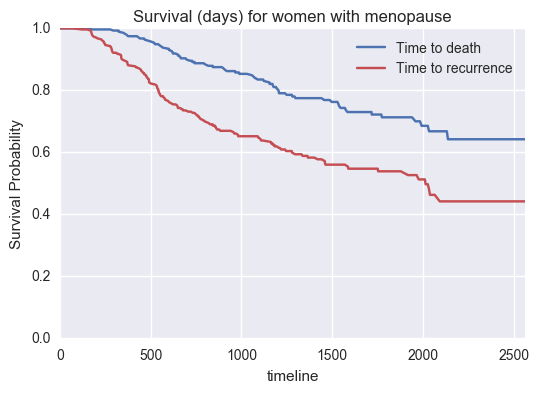

In [276]:
#lets plot for menopause status
plot_recurrence_and_death(m1, "Survival (days) for women with menopause")

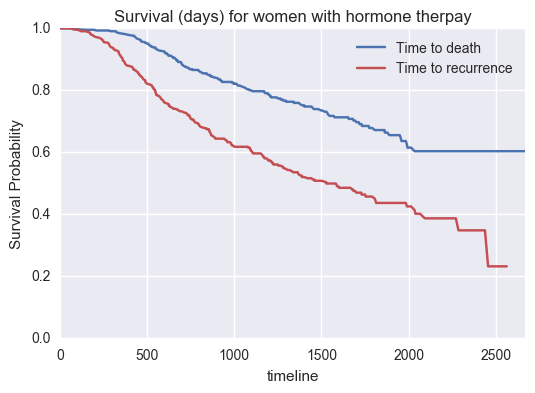

In [277]:
#lets plot for hormone therapy
plot_recurrence_and_death(h1, "Survival (days) for women with hormone therpay")

# Nelson Aalen and Cumulative Hazards

In a similar fashion to how we performed the `KaplanMeierFitter()` to our data, we can also perform a `NelsonAalenFitter()` function to obtain Nelson Aalen estimates and cumulative hazards by specifying `.cumulative_hazard_`

          NA_estimate
timeline             
0.0          0.000000
8.0          0.000000
15.0         0.000000
16.0         0.000000
17.0         0.000000
18.0         0.000000
29.0         0.000000
42.0         0.000000
46.0         0.000000
57.0         0.000000
63.0         0.000000
65.0         0.000000
67.0         0.000000
71.0         0.000000
72.0         0.001488
114.0        0.001488
140.0        0.002981
148.0        0.002981
168.0        0.002981
177.0        0.004480
186.0        0.004480
195.0        0.004480
210.0        0.005988
213.0        0.005988
229.0        0.005988
273.0        0.005988
275.0        0.007506
276.0        0.007506
294.0        0.009028
296.0        0.009028
...               ...
2282.0       0.481107
2286.0       0.481107
2296.0       0.481107
2297.0       0.481107
2313.0       0.481107
2320.0       0.481107
2353.0       0.481107
2359.0       0.481107
2370.0       0.481107
2372.0       0.481107
2380.0       0.481107
2385.0       0.481107
2388.0    

(0, 1)

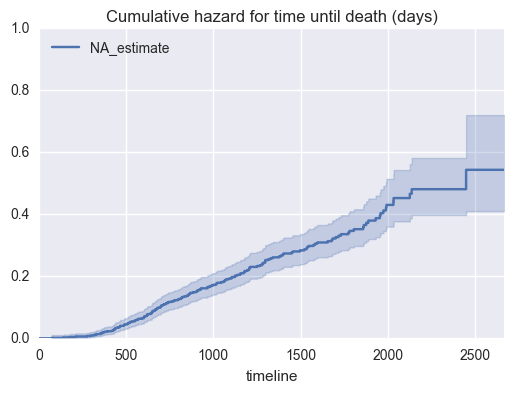

In [306]:
#assign the fitter
nelson = NelsonAalenFitter()

#assign the model
nelson.fit(S, event_observed=D)

#print out the cumulative hazards
print(nelson.cumulative_hazard_)

#plot with a title
nelson.plot(title='Cumulative hazard for time until death (days)')
plt.legend(loc='upper left')
plt.ylim([0,1])

We can specify which variables or features of interest we want the Nelson Aalen estimates and cumulative hazard plot for, just as we did for the `KaplanMeierFitter()` methods   
  
  Below we'll calculate the cumulative hazards (Nelson Aalen estimates) for menopausal status and label the output from something different than `NA_estimate`, then we'll define a function to plot the cumulative hazards over time

In [298]:
#define the fitter
nelsonM=NelsonAalenFitter()

#fit the model with the nelson aalen estimator
#call on survival for menopauseal status and label the output
nelsonM.fit(S[m1], event_observed=D[m1], label="Cumulative hazard (Nelson Aalen) for Menopause==1")

#print the output
print(nelsonM.cumulative_hazard_)

          Cumulative hazard (Nelson Aalen) for Menopause==1
timeline                                                   
0.0                                                0.000000
8.0                                                0.000000
16.0                                               0.000000
17.0                                               0.000000
42.0                                               0.000000
57.0                                               0.000000
67.0                                               0.000000
71.0                                               0.000000
148.0                                              0.000000
177.0                                              0.003559
195.0                                              0.003559
273.0                                              0.003559
276.0                                              0.003559
294.0                                              0.007182
296.0                                   

Now we'll define a function to plot these cumulative hazard estimates

In [307]:
#defining a function to plot the estimates
def cumulative_haz_nelson(var, titleName, legend1, legend2):
    nelson.fit(S[var], event_observed=D[var], label=legend1)
    ax=nelson.plot()
    ax.plot(range(1))
    
    nelson.fit(S[~var], event_observed=D[~var], label=legend2)
    nelson.plot(ax=ax)
    ax.set_ylabel('Cumulative Hazard')
    
    ax.set_title(titleName)
    plt.legend(loc='upper left')
    plt.ylim([0,1])

We can run this function for dichotomous features, such as menopause and hormone therapy

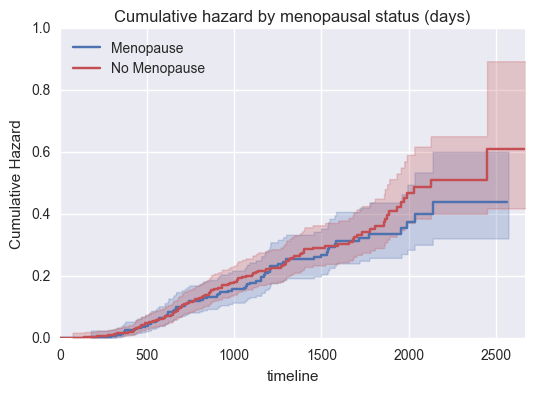

In [308]:
menoHazard = cumulative_haz_nelson(m1, "Cumulative hazard by menopausal status (days)", 'Menopause', 'No Menopause')
menoHazard

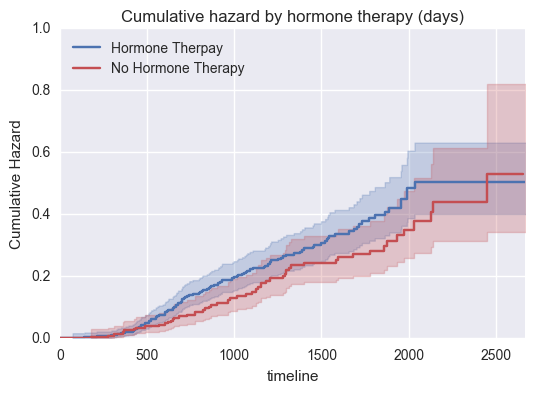

In [309]:
hormHazard = cumulative_haz_nelson(h1, 'Cumulative hazard by hormone therapy (days)', 'Hormone Therpay', 'No Hormone Therapy')
hormHazard

The hazards accumulated over time are similar for menopausal status. However the hazards for hormone therapy suggest those receiving hormone therapy are accumulating a higher rate of hazard than those receiving no hormone therapy  

Like before, we can fit a cumulative hazard model for the polychotomous factor 'tumor grade'

(0, 1)

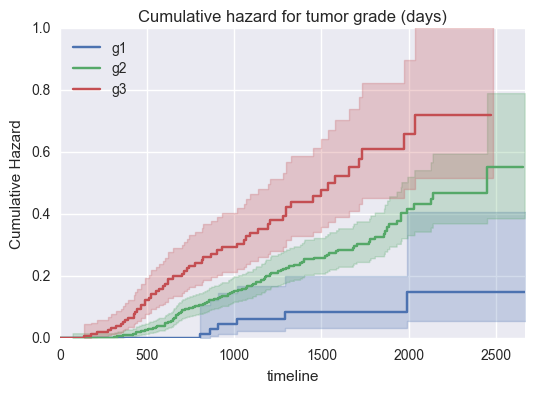

In [311]:
#fit nelson for the tumor grades 1-3
nelsong1 = NelsonAalenFitter()
nelsong1.fit(S[g1], event_observed=D[g1], label='g1')
ax=nelsong1.plot()

nelsong2 = NelsonAalenFitter()
nelsong2.fit(S[g2], event_observed=D[g2], label='g2')
nelsong2.plot(ax=ax)

nelsong3 = NelsonAalenFitter()
nelsong3.fit(S[g3], event_observed=D[g3], label='g3')
nelsong3.plot(ax=ax)


ax.set_ylabel('Cumulative Hazard')
ax.legend(loc='upper left')
ax.set_title("Cumulative hazard for tumor grade (days)")
plt.ylim([0,1])

# Kernel Smoothing of the Cumulative Hazards

Python is capable of plotting cumulative hazards as smooth function (kernel estimator) using only the Epanechnikov method of smoothing. To do so, we use the `plot_hazard()` function and specify the `bandwith` parameter  

Below we will plot this Epanechnikov Kernel smoother stratified on tumor grade

In [288]:
#accessing the NelsonAalenFitter() directory to show that plot_hazard is an available function
dir(nelson)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_additive_f',
 '_additive_f_discrete',
 '_additive_f_smooth',
 '_bounds',
 '_conditional_time_to_event_',
 '_cumulative_sq',
 '_divide',
 '_label',
 '_plot_estimate',
 '_predict',
 '_subtract',
 '_variance_f',
 '_variance_f_discrete',
 '_variance_f_smooth',
 'alpha',
 'ci_labels',
 'conditional_time_to_event_',
 'confidence_interval_',
 'cumulative_hazard_',
 'divide',
 'durations',
 'entry',
 'event_observed',
 'event_table',
 'fit',
 'nelson_aalen_smoothing',
 'plot',
 'plot_cumulative_hazard',
 'plot_hazard',
 'predict',
 'smoothed_hazard_',
 'smoothed_hazard_confidence_intervals_',
 'subtract',
 'timeline']

Note: To ensure this method of plotting the kernel estimates worked properly, I ran this side by side in SAS using the following code:  

`proc lifetest data=work.import nelson method=pl plots=hazard(kernel=E);  
time survtime*censdead(0);  
strata grade;  
run;  `

By doing so, I used the bandwidths that SAS uses to see how well this aligns. This is the reasoning for the choice of bandwidth used below

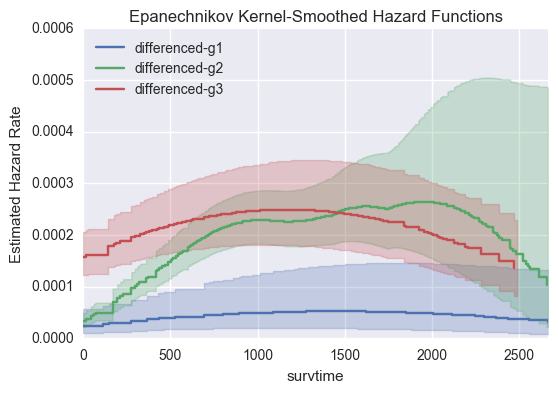

In [363]:
#fitting nelson like before
ax=nelsong1.plot_hazard(bandwidth=2006.77)

nelsong2.plot_hazard(ax=ax, bandwidth=706.67)

nelsong3.plot_hazard(ax=ax, bandwidth=1993.59)

#labeling
ax.set_ylabel('Estimated Hazard Rate')
ax.set_xlabel('survtime')
ax.legend(loc='upper left')
ax.set_title("Epanechnikov Kernel-Smoothed Hazard Functions");

These smoothed estimates look very similar between 0 and 2000 days, and then fairly different at about 2000 days and onward between SAS and Python - that is okay, as the confidence intervals are still within the range of SAS's output. There may be numerical instability in either program, and censorship/sparsity of data near 2000 days may be treated differently between the programs  
  
  For proof's sake, below is the Kernel smoother from SAS output. We see that overall we're within good range

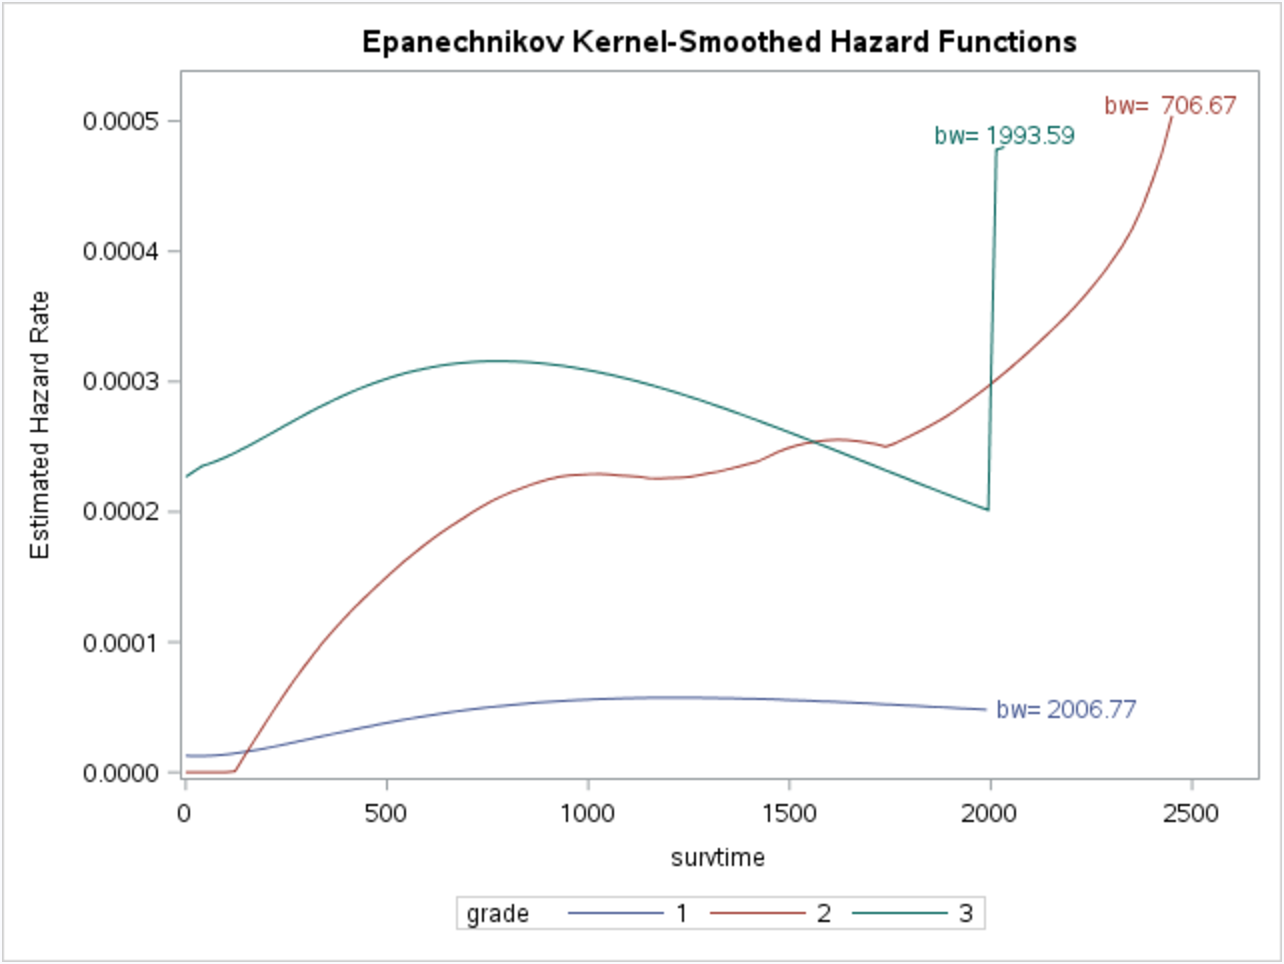

In [333]:
#from IPython.display import Image
Image(filename='Desktop/epan.png')

# Checking proportional hazards

If you are familiar with using SAS for survival analysis, then it is likely are aware of using PROC LIFETEST to plot an 'LLS' curve of the stratified variable as a visual check for proportionality of hazards. If you aren't familiar with this, then idea is to transform your Kaplan Meier survival curves by plotting log(-log(survival curve)) vs log(time), where if the curves are parallel and do not cross eachother, then it's likely your stratified variable satifies proportionality of hazards and you don't necessarily have to stratify on that variable for a regression model. However, if the curves are not parallel and cross, then the hazards are not proportional and you'll need to stratify on that variable for your model. Why do we care about this? Because if you don't meet the criteria of proportional hazards, then you cannot perform Cox Proportional Hazards regression for your data
  
  Python does not have this feature, which means we'll have to look into the directory of our Kaplan Meier function and get creative with coding this up ourselves  
  
  `dir()` is a directory function that will display all functions/attributes available for an object. In our case, anytime we call on `dir()`, we will be looking at the attributes forom the output of a *Fitter* function  
  
  If we search one the fitted Kaplan Meier models, we will see all output provided from fitting a model. By searching on `KMm`, a model we created for menopause, we see that `survival_function_` is something that can be used. We'll use the estimates provided from this attribute to create an LLS plot

In [194]:
#accessing the directory of the KM function
dir(KMm)

['_KaplanMeierFitter__estimate',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_additive_f',
 '_additive_var',
 '_bounds',
 '_conditional_time_to_event_',
 '_divide',
 '_label',
 '_plot_estimate',
 '_predict',
 '_subtract',
 'alpha',
 'conditional_time_to_event_',
 'confidence_interval_',
 'divide',
 'durations',
 'entry',
 'event_observed',
 'event_table',
 'fit',
 'median_',
 'plot',
 'plot_survival_function_',
 'predict',
 'subtract',
 'survival_function_',
 'timeline']

Let's look into this `survival_function_`

In [195]:
KMm.survival_function_

,Menopause
timeline,
0.0,1.000000
8.0,1.000000
16.0,1.000000
17.0,1.000000
42.0,1.000000
57.0,1.000000
67.0,1.000000
71.0,1.000000
148.0,1.000000


Notice how the timeline is not actually a column, it's being treated as an index. We can use the `.reset_index()` function from pandas to fix this so we can access the timeline as a column

In [191]:
KM.survival_function_.reset_index()

,timeline,Time to recurrence
0,0.0,1.000000
1,8.0,1.000000
2,16.0,1.000000
3,17.0,1.000000
4,42.0,1.000000
5,57.0,1.000000
6,67.0,1.000000
7,71.0,1.000000
8,120.0,0.996454
9,148.0,0.996454


So we've got our Kaplan Meier survival probability estimates, now we just need to stratify by the variable of interest and transform the data to an LLS plot. To do so, we will use numpy (np) to operate a logarithm on every element of an array. We do this because the `survival_function_` provides an array of values  
  
We will demonstrate this by stratifying for tumor grade

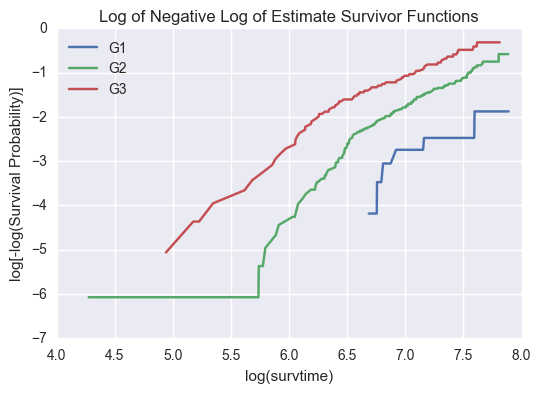

In [267]:
#set up multiple subplots to overlay
ax=plt.subplot(111)

#fit tumor grade 1
KM_g1 = KaplanMeierFitter()
KM_g1.fit(S[g1], D[g1], label='G1')

#set up a plot for the log of time (reset the index) by accessing the timeline - xaxis
#then set up the yaxis for the log(-log of the survival function for tumor grade 1)
ax.plot(
    np.log(KM_g1.survival_function_.reset_index().timeline),
    np.log(-np.log(KM_g1.survival_function_.G1)),
)

#now do the same for grade 2
KM_g2 = KaplanMeierFitter()
KM_g2.fit(S[g2], D[g2], label='G2')
ax.plot(
    np.log(KM_g2.survival_function_.reset_index().timeline),
    np.log(-np.log(KM_g2.survival_function_.G2)),
)

#and grade 3
KM_g3 = KaplanMeierFitter()
KM_g3.fit(S[g3], D[g3], label='G3')
ax.plot(
    np.log(KM_g3.survival_function_.reset_index().timeline),
    np.log(-np.log(KM_g3.survival_function_.G3)),
)

#move the location of the legend
ax.legend(loc='upper left')

#labels and title
#note: I've given these titles/labels the same names as SAS outputs
ax.set_xlabel('log(survtime)')
ax.set_ylabel('log[-log(Survival Probability)]')
plt.title("Log of Negative Log of Estimate Survivor Functions")

This obviously satisfies the proportional hazards check, as each of the curves are parallel and do not cross. Thus, for further analysis we have no need to stratify by this variable  
  
Let's turn this method of LLS plot into a function and pass through dichotomous variables

In [268]:
def proportional_hazards(var, time, legend1, legend2):
    ax=plt.subplot(111)
    
    KM1 = KaplanMeierFitter()
    KM1.fit(S[var], D[var], label=legend1)

    #print('-', KM1.survival_function_.columns)
    ax.plot(
        np.log(KM1.survival_function_.reset_index().timeline),
        np.log(-np.log(KM1.survival_function_[legend1])),
    )
    ax.plot(range(0))
    KM2 = KaplanMeierFitter()
    KM2.fit(S[~var], D[~var], label=legend2)
    ax.plot(
        np.log(KM2.survival_function_.reset_index().timeline),
        np.log(-np.log(KM2.survival_function_[legend2])),
    )

    ax.legend(loc='upper left')
    
    #example of how we can pass an argument into a string
    ax.set_xlabel('log(%s)' % time)
    ax.set_ylabel('log[-log(Survival Probability)]')
    plt.title('Log of Negative Log of Estimate Survivor Functions')

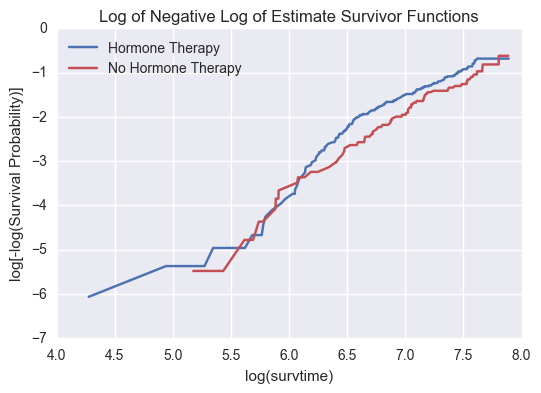

In [269]:
#now we call this function with hormone therapy use
proportional_hazards(h1, 'survtime', 'Hormone Therapy', 'No Hormone Therapy')

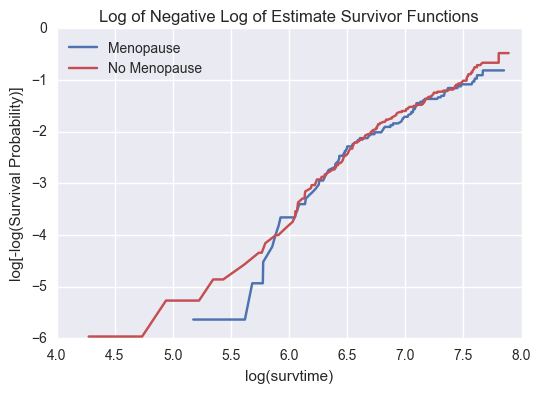

In [270]:
#now try it out for menopause status
proportional_hazards(m1, 'survtime', 'Menopause', 'No Menopause')

Clearly, both menopausal status and hormone therapy do not satify proportional hazards, hence we wish to stratify on both hormones and menopausal status when performing a Cox PH regression on the data

# Cox Proportional Hazards Regression

Just like before, running a Cox PH regression model is similar in that we define our fitter, fit the model, and output the model/plot. We do so by using `CoxPHFitter()` and `.print_summary()`
  
  Below we will explore different models for this dataset, where at this point, we know in order to run a Cox regression that we'll need to stratify on menopause and hormones for a meaningful analysis. However we'll start by running a general model, and then dive into the details

In [336]:
#a general cox model
cox = CoxPHFitter()
#specify the dataframe, the variable of interest, and the censoring event
cox.fit(cancerData, 'survtime', event_col='censdead')
cox.print_summary()

n=686, number of events=171

                 coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
age         2.316e-01  1.261e+00 1.211e-01  1.913e+00 5.577e-02  -5.763e-03   4.689e-01    .
menopause  -5.784e-02  9.438e-01 1.356e-01 -4.266e-01 6.696e-01  -3.236e-01   2.079e-01     
hormone    -6.827e-02  9.340e-01 8.326e-02 -8.200e-01 4.122e-01  -2.315e-01   9.495e-02     
size        1.695e-01  1.185e+00 6.719e-02  2.523e+00 1.165e-02   3.778e-02   3.012e-01    *
grade       1.674e-01  1.182e+00 9.497e-02  1.762e+00 7.803e-02  -1.882e-02   3.535e-01    .
nodes       5.071e-02  1.052e+00 6.936e-02  7.311e-01 4.647e-01  -8.526e-02   1.867e-01     
prog_recp  -7.031e-01  4.950e-01 2.162e-01 -3.253e+00 1.142e-03  -1.127e+00  -2.794e-01   **
estrg_recp -6.394e-02  9.381e-01 7.780e-02 -8.218e-01 4.112e-01  -2.165e-01   8.859e-02     
rectime    -1.276e+00  2.791e-01 1.470e-01 -8.684e+00 3.834e-18  -1.564e+00  -9.882e-01  ***
censrec     2.044e+01  7.564e+08 4.162e+0

Notice how using this general model includes all variables. In order to specify which covariates to include in the model, we have to create another dataframe by dropping the variables we do not wish to include   
  
  
  From this model, we see that censrec is not of statistical significance, thus we'll omit this from the model and run a new Cox regression. Additionally, we'll stratify on the covariates hormone and menopause

In [337]:
#drop the column, columns are axis=1, rows are axis=0
cancerDataNew=cancerData.drop(['censrec'], axis=1)
cox_with_variables = CoxPHFitter()
cox_with_variables.fit(cancerDataNew, 'survtime', event_col='censdead', 
                       strata=['hormone', 'menopause'], include_likelihood=True)
cox_with_variables.print_summary()

n=686, number of events=171

                 coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
age         2.738e-01  1.315e+00 1.259e-01  2.174e+00 2.968e-02   2.694e-02   5.207e-01    *
size        1.700e-01  1.185e+00 6.825e-02  2.490e+00 1.277e-02   3.616e-02   3.038e-01    *
grade       1.653e-01  1.180e+00 9.481e-02  1.743e+00 8.131e-02  -2.060e-02   3.511e-01    .
nodes       7.870e-02  1.082e+00 6.574e-02  1.197e+00 2.313e-01  -5.018e-02   2.076e-01     
prog_recp  -7.438e-01  4.753e-01 2.140e-01 -3.475e+00 5.103e-04  -1.163e+00  -3.242e-01  ***
estrg_recp -5.893e-02  9.428e-01 7.785e-02 -7.570e-01 4.490e-01  -2.115e-01   9.368e-02     
rectime    -1.906e+00  1.487e-01 1.424e-01 -1.338e+01 7.713e-41  -2.185e+00  -1.627e+00  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.920


Concordance is similar to an AUC (area under the curve) score for an ROC graph, generally the closer to 1 the better. However, in terms of building a prognostic model, what about an AIC score? What about hypothesis testing?   

# Statistics and model building

We can run a logrank, pairwise logrank, or multivariate logrank test on these survival curves using a statistics package from *Lifelines*. For now we cover the log-rank test and demonstrate for menopausal status and hormone therapy using the `log_rank()` function

In [360]:
#from lifelines.statistics import logrank_test
#input survival with and without the variable in question
#input censorship with and without the variable in question
#input the alpha significance level 

summaryMenopause=logrank_test(S[m1], S[~m1], D[m1], D[~m1], alpha=.95)
summaryMenopause.print_summary()

Results
   t 0: -1
   df: 1
   alpha: 0.95
   null distribution: chi squared
   test: logrank

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.48378 |              0.490 |  Cannot Reject Null |       False       


In [361]:
#we can also just print it directly
logrank_test(S[h1], S[~h1], D[h1], D[~h1], alpha=.95).print_summary()

Results
   t 0: -1
   df: 1
   alpha: 0.95
   null distribution: chi squared
   test: logrank

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.10949 |              2.562 |  Cannot Reject Null |       False       


We fail to reject the null hypothesis for either of these models, and thus we cannot claim the curves are statistically significant from one another for each model

Being able to run a log-rank test is handy. But often time when model building we wish to look to an AIC score and the likelihood ratio test (LRT). Since Python doesn't have any functions ready to use like `log_rank()`, we'll have to develop these ourselves  
  
  By accessing `dir()` like we've done before, we find that the cox fitter provides an attribute name `_log_likelihood.` From this we can derive the AIC score and LRT

In [338]:
dir(cox)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_values',
 '_compute_baseline_hazard',
 '_compute_confidence_intervals',
 '_compute_p_values',
 '_compute_standard_errors',
 '_compute_z_values',
 '_get_efron_values',
 '_hessian_',
 '_newton_rhaphson',
 '_norm_mean',
 '_norm_std',
 '_score_',
 'alpha',
 'baseline_cumulative_hazard_',
 'baseline_hazard_',
 'baseline_survival_',
 'confidence_intervals_',
 'data',
 'durations',
 'event_observed',
 'fit',
 'hazards_',
 'normalize',
 'penalizer',
 'predict_cumulative_hazard',
 'predict_expectation',
 'predict_log_hazard_relative_to_mean',
 'predict_median',
 'predict_partial_hazard',
 'predict_percentile',
 'predict_survival_function',
 'pr

By definition, $~AIC = -2log(likelihood) + 2K$ where $K$ is the number of parameters in the model (degrees of freedom)

When running this model in SAS we get an AIC of 1237.464 with 7 DOF, let's see what Python gives us

In [44]:
cox_with_variables._log_likelihood

-611.5712389697278

In [45]:
-2*(cox_with_variables._log_likelihood) + 2*7

1237.1424779394556

Hooray! SAS and Python agree. We can now turn this into a function. But, in order to know whether our model is improving, we need to know what the AIC is for baseline model (the model without covariates)  
  
  By defining an AIC function and calculating our baseline model, we can take their difference and obtain the $G$ statistic used for the LRT

In [339]:
def cox_AIC(model, param):
    return (-2*(model._log_likelihood) + 2*param)

In [340]:
#AIC
cox_AIC(cox_with_variables, 7)

1237.1424779394556

In [341]:
#define the baseline/null model
cancerDataNull=cancerData.drop(['censrec', 'age', 'size', 'grade', 'nodes', 'prog_recp', 'estrg_recp', 'rectime'], axis=1)
cox_without_variables = CoxPHFitter()
cox_without_variables.fit(cancerDataNull, 'survtime', event_col='censdead', strata=['hormone', 'menopause'], include_likelihood=True)
cox_without_variables.print_summary()
cox_without_variables._log_likelihood

n=686, number of events=171

Empty DataFrame
Columns: [coef, exp(coef), se(coef), z, p, lower 0.95, upper 0.95, ]
Index: []
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.500


-807.77798170342555

In [342]:
#baseline
withoutVariables=cox_AIC(cox_without_variables, 0)
print(withoutVariables)

1615.55596341


Hence, 1237.14 is the AIC score of our model with covariates, and 1615.55 is baseline null model to which can compare our current model to  

In order to calculate the likelihood ratio test, we'll need to hard code it ourselves and derive the estimates. Since the cox function gives us the log-likelihood estimates, this shouldn't be too hard  

What we need to know first, is that instead of using the AIC estimates, we need to use the $-2log(likelihood)$ estimates - which means we can just use our AIC function, and pass in 0 for the $K$ parameter

In [343]:
#LRT
withVariables=cox_AIC(cox_with_variables, 0)
print(withVariables)

1223.14247794


Thus, the $-2log(likelihood)$ estimate is 1223.14  (again matching SAS output)

The $G$ statistic, which follows a chi-square distribution with $K$ degrees of freedom, is then calculated as the difference of our baseline model and our model with covariates  
  
  Let this difference be denoted by $X$, then LRT is the following: $~\mathbb{P}[G > \chi^2 (K)] < p.value$  
  
  Below, we will define a function to calculate this for us

In [375]:
def chiSquare_G(withoutVar, withVar):
    chiSquare_G = withoutVariables - withVariables
    return chiSquare_G

In [345]:
chiSquare_G(withoutVariables, withVariables)

392.4134854673955

This is very close to what SAS provides, and if you know a thing or two about statistics, then you probably don't need a chi-square distribution table to know that the probability of this value (392.41) being greater than a chi-square with 7 degrees of freedom is very, very, small
  
Meaning $\mathbb{P}[392.41 > \chi^2 (7)] < 0.0001$. Thus, our model is significantly different from the null model (with no covariates)

# Hazard Ratios and Confidence Intervals

The hazard ratios are not labeled as the 'hazard ratio' or 'HR' here in the output - but they are provided in the second column labeled exp(coef). If we wanted to look at them separately, we can use the `.hazards_` attribute found by searching `dir()` for the Cox Fitter output, and then calling numpy to perform an exponential function on the array of values using `np.exp()`

In [53]:
np.exp(cox_with_variables.hazards_)

,age,size,grade,nodes,prog_recp,estrg_recp,rectime
coef,1.314986,1.185259,1.179703,1.081875,0.47531,0.942769,0.148684


The confidence intervals are provided by the 'lower' and 'upper' from the output. However the statistical notation is difficult to follow. To obtain the confidence intervals in a more readable format we could print them out like we did the hazard ratios using `.confidence_intervals_` 

Better yet, we'll just define a function to concatenate these two features into a single output using `pd.concat`, which is calling on the pandas package to concatenate the two features

In [349]:
def confInt(model):
    C = model.hazards_
    CI = model.confidence_intervals_
    return pd.concat([C, CI], axis=0)

def hazInt(model):
    HR = np.exp(model.hazards_)
    HCI = np.exp(model.confidence_intervals_)
    #we need to rename coef to HR, otherwise it won't make sense for what we're looking at
    return pd.concat([HR, HCI], axis=0).rename({'coef': 'HR'})

In [347]:
confInt(cox_with_variables)

,age,size,grade,nodes,prog_recp,estrg_recp,rectime
coef,0.273826,0.169961,0.165263,0.078696,-0.743787,-0.058934,-1.905930
lower-bound,0.026942,0.036162,-0.020597,-0.050175,-1.163352,-0.211546,-2.185141
upper-bound,0.520710,0.303760,0.351122,0.207567,-0.324223,0.093677,-1.626719


In [348]:
hazInt(cox_with_variables)

,age,size,grade,nodes,prog_recp,estrg_recp,rectime
HR,1.314986,1.185259,1.179703,1.081875,0.475310,0.942769,0.148684
lower-bound,1.027308,1.036824,0.979614,0.951063,0.312437,0.809332,0.112462
upper-bound,1.683223,1.354944,1.420661,1.230681,0.723089,1.098205,0.196573


# Wrapping it all up

Without going too far into an analysis, we'll take a quick look at modifying this current model into something a little bit better  
  
  Both nodes and estrogen receptors are non-significant, we'll remove these and keep an eye on our AIC score

In [351]:
cancerDataSig=cancerDataNew.drop(['nodes', 'estrg_recp'], axis=1)
cox_sig_variables = CoxPHFitter()
cox_sig_variables.fit(cancerDataSig, 'survtime', event_col='censdead', strata=['hormone', 'menopause'], include_likelihood=True)
cox_sig_variables.print_summary()

n=686, number of events=171

                coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
age        2.812e-01  1.325e+00 1.238e-01  2.271e+00 2.314e-02   3.847e-02   5.238e-01    *
size       1.981e-01  1.219e+00 6.372e-02  3.109e+00 1.878e-03   7.318e-02   3.230e-01   **
grade      1.887e-01  1.208e+00 9.283e-02  2.033e+00 4.205e-02   6.740e-03   3.707e-01    *
prog_recp -7.576e-01  4.688e-01 2.115e-01 -3.582e+00 3.409e-04  -1.172e+00  -3.430e-01  ***
rectime   -1.929e+00  1.454e-01 1.413e-01 -1.365e+01 2.105e-42  -2.206e+00  -1.652e+00  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.920


In [352]:
cox_AIC(cox_sig_variables, 5)

1234.8116952302182

Our AIC has improved from our previous model and the baseline, suggesting a better fit. Below we calculate the LRT

In [58]:
sigVariables=cox_AIC(cox_sig_variables, 0)
sigVariables

1224.8116952302182

In [59]:
chiSquare_G(withoutVariables, sigVariables)

392.4134854673955

We don't have to go much further from here to know that the LRT will be statistically significant. Below we inspect and interpret the coefficients of the hazard ratios and their respective confidence intervals

In [350]:
hazInt(cox_sig_variables)

,age,size,grade,prog_recp,rectime
HR,1.324663,1.219082,1.207717,0.468789,0.145358
lower-bound,1.039222,1.075927,1.006763,0.309677,0.110185
upper-bound,1.688506,1.381284,1.448782,0.709651,0.191759


From this output we see tha an increase in the time to recurrence of breast cancer has an 85.5% protective effective in the hazard of time until death. An increase in progesterone receptors within in the body results in a 53.2% protective effective in the hazard of time until death. However, age of the women, size of the tumor, and tumor grade all are associated with an increased risk of hazard (death). The risk associated with a 1 unit increase in age results in a 1.32x higher risk of death than those younger in age. The risk associated with a 1 unit increase in tumor size results in a 1.22x higher risk of death than no increase in tumor size. Lastly, the risk associated with an increase in tumor grade results in a 1.21x higher risk of death compared to those at a lower grade  
  
  _**Note: This is not an extensive analysis of the data nor robut model building, rather it is simply showing some of the basic capabilities for survival analysis in Python**_

# Congratulations!

If you've stuck with me this far, then you've reached the end of the tutorial on how to utilize Python for survival analytics. It is my hope that this has been a useful resource for you to pick up a few skills toward mastering the language of Python
